In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, auc
import shap
from sklearn.metrics import classification_report

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
df = pd.read_csv('online_retail_cleaned.csv')

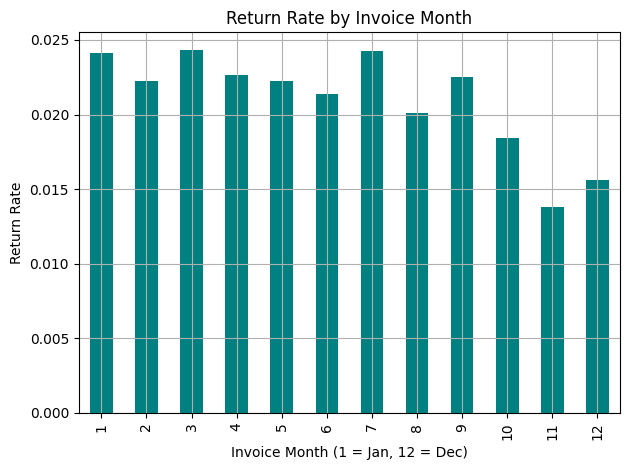

In [18]:
# Assuming you have a DataFrame `df` with 'InvoiceMonth' and 'IsReturn'
return_rate_by_month = df.groupby('InvoiceMonth')['IsReturn'].mean()

# Plot
return_rate_by_month.plot(kind='bar', color='teal')
plt.title('Return Rate by Invoice Month')
plt.xlabel('Invoice Month (1 = Jan, 12 = Dec)')
plt.ylabel('Return Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.get_dummies(df, columns=['InvoiceHour'], prefix='InvoiceHour_')
df = pd.get_dummies(df, columns=['InvoiceMonth'], prefix='InvoiceMonth_')

# Define target variable
y = df['IsReturn']

# Drop columns that should not be used as features
X = df.drop(columns=['Customer ID','IsReturn', 'Invoice', 'InvoiceDate', 'StockCode','Description',"Country"]) 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Ensures class ratio consistency
    random_state=42
)

In [10]:
# weight ratio between the majority class (non-returns) and the minority class (returns) in the training data.
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 49.08


In [6]:
def execute_model(scale_pos_weight):
    xgb_model = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        random_state=42
    )

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
    print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
    
    return xgb_model, y_pred, y_pred_proba

In [9]:
xgb_model, y_pred, y_pred_proba = execute_model(scale_pos_weight)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [23:30:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.81      0.89    157907
           1       0.08      0.78      0.14      3217

    accuracy                           0.81    161124
   macro avg       0.54      0.79      0.52    161124
weighted avg       0.98      0.81      0.88    161124

AUC-ROC: 0.8890574727687964
AUC-PR: 0.24557620642799188


In [7]:
# Top 5% Precision
def precision_at_k(y_test, y_pred_custom, k_percent=0.05):
    df_preds = pd.DataFrame({
        'proba': y_pred_custom,         # predicted probabilities for class 1
        'actual': y_test               # true labels (0 or 1)
    })

    # Sort by predicted probability descending (most return-like first)
    df_preds = df_preds.sort_values(by='proba', ascending=False).reset_index(drop=True)

    # Define Top-K% (e.g., top 5%)
    K = int(len(df_preds) * k_percent)

    # Slice top K rows
    top_k = df_preds.iloc[:K]

    # Calculate Top-K Precision
    precision_at_k = top_k['actual'].sum() / K
    print(f"Top-{k_percent*100:.0f}% Precision: {precision_at_k:.4f}")
    return df_preds

In [12]:
df_preds = precision_at_k(y_test, y_pred_proba, k_percent=0.05)

Top-5% Precision: 0.1822


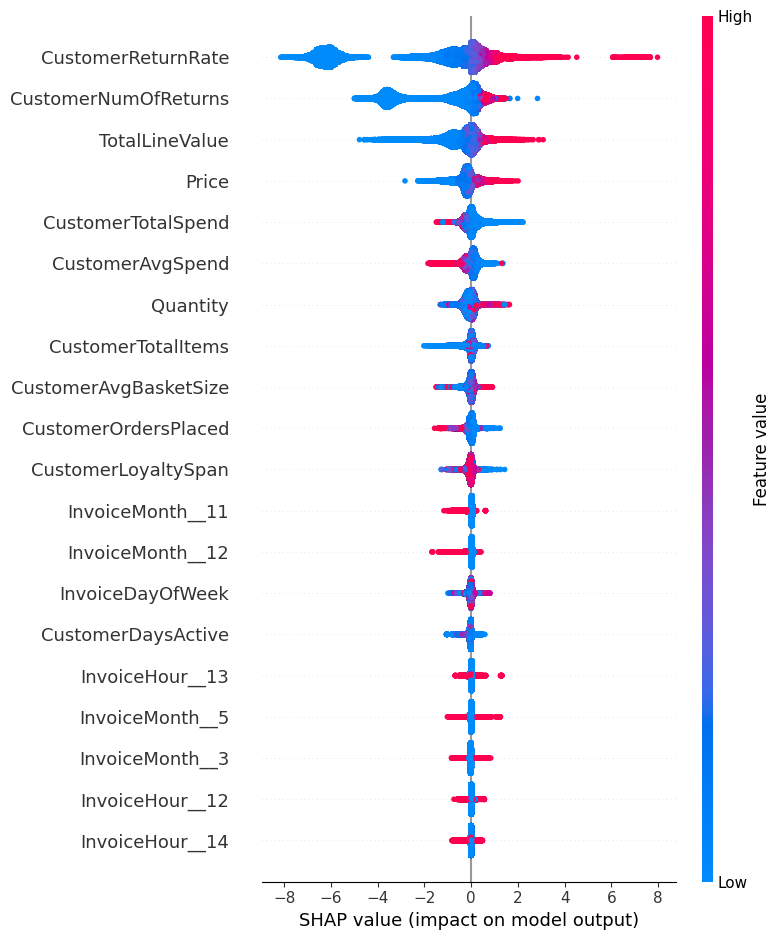

In [13]:
# Initialize the TreeExplainer
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_train)

# Summary plot - shows top features across the entire dataset
shap.summary_plot(shap_values, X_train)

#### Try with cyclical encoding

In [11]:
df = pd.read_csv('online_retail_cleaned.csv')

def cyclical_encode(df, col_name, period):
    df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / period)
    df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / period)
    return df

# Assuming your DataFrame is 'df' and the month column is 'InvoiceMonth'
df = cyclical_encode(df, 'InvoiceMonth', 12)
df = df.drop('InvoiceMonth', axis=1) # Drop the original InvoiceMonth column

# Assuming your DataFrame is 'df' and the month column is 'InvoiceHour'
df = cyclical_encode(df, 'InvoiceHour', 24)
df = df.drop('InvoiceHour', axis=1) 

# Define target variable
y = df['IsReturn']

# Drop columns that should not be used as features
X = df.drop(columns=['Customer ID','IsReturn', 'Invoice', 'InvoiceDate', 'StockCode','Description',"Country"]) 

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Ensures class ratio consistency
    random_state=42
)

In [12]:
xgb_model_cyclical, y_pred, y_pred_proba = execute_model(scale_pos_weight)

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    157907
           1       0.08      0.79      0.14      3217

    accuracy                           0.81    161124
   macro avg       0.54      0.80      0.52    161124
weighted avg       0.98      0.81      0.88    161124

AUC-ROC: 0.8908735415436045
AUC-PR: 0.24261133562512321


In [13]:
df_preds = precision_at_k(y_test, y_pred_proba, k_percent=0.05)

Top-5% Precision: 0.1816


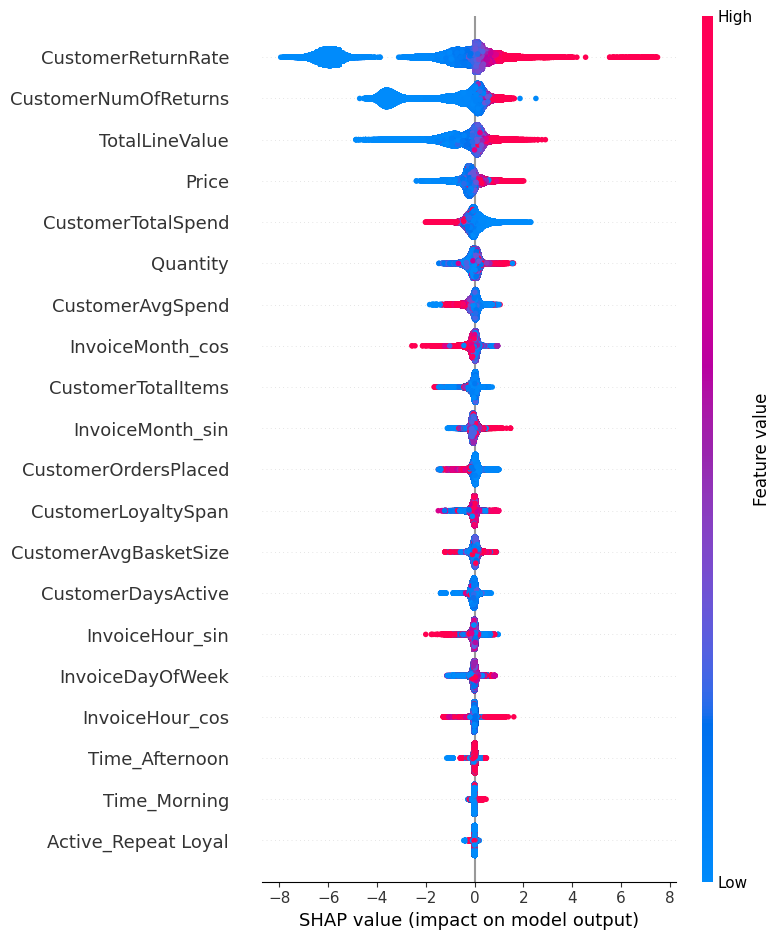

In [14]:
# Initialize the TreeExplainer
explainer = shap.Explainer(xgb_model_cyclical)

# Compute SHAP values
shap_values = explainer(X_train)

# Summary plot - shows top features across the entire dataset
shap.summary_plot(shap_values, X_train)

Use cyclical encoding:
- Slightly better recall and AUC-ROC (your top priorities)
- More compact feature space (2 cols vs. 12+)
- SHAP interpretation is cleaner and more continuous
- Ideal for models with seasonal patterns (like returns)